In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Untuk menghasilkan output grafik yang interaktif di Colab:
%matplotlib inline


In [5]:
def load_dataset(url, target_col=None):
    # Membaca dataset
    df = pd.read_csv(url)

    # Jika target_col tidak dispesifikasikan, gunakan kolom terakhir
    if target_col is None:
        target_col = df.columns[-1]

    # Cetak info dataset untuk verifikasi
    print(f"Dataset loaded from {url}")
    print("Dimensi Dataset:", df.shape)
    print("Kolom yang tersedia:", df.columns.tolist())

    # Preprocessing sederhana:
    # - Hilangkan baris dengan nilai null
    df = df.dropna().reset_index(drop=True)
    # - Konversi variabel kategorikal ke numerik bila ada (menggunakan one-hot encoding)
    df = pd.get_dummies(df, drop_first=True)

    # Menentukan fitur dan target
    X = df.drop(columns=[target_col])
    y = df[target_col]

    return df, X, y

# Evaluasi dan Pelatihan

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from typing import Dict, Tuple, Optional, Union
import warnings
import logging

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


class GradientBoostingTrainer:
    """
    Professional Gradient Boosting Regressor trainer with comprehensive evaluation and visualization.

    This class provides a complete pipeline for training, evaluating, and visualizing
    Gradient Boosting models with professional-grade features including cross-validation,
    comprehensive metrics, and publication-ready visualizations.
    """

    def __init__(
        self,
        n_estimators: int = 100,
        learning_rate: float = 0.1,
        max_depth: int = 3,
        random_state: int = 42,
        subsample: float = 1.0,
        min_samples_split: int = 2,
        min_samples_leaf: int = 1,
        max_features: Optional[Union[int, float, str]] = None
    ):
        """
        Initialize the Gradient Boosting Trainer.

        Args:
            n_estimators: Number of boosting stages to perform
            learning_rate: Learning rate shrinks the contribution of each tree
            max_depth: Maximum depth of the individual regression estimators
            random_state: Random state for reproducibility
            subsample: Fraction of samples used for fitting individual base learners
            min_samples_split: Minimum number of samples required to split internal node
            min_samples_leaf: Minimum number of samples required to be at leaf node
            max_features: Number of features to consider when looking for best split
        """
        self.model_params = {
            'n_estimators': n_estimators,
            'learning_rate': learning_rate,
            'max_depth': max_depth,
            'random_state': random_state,
            'subsample': subsample,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf,
            'max_features': max_features
        }
        self.model = None
        self.scaler = None
        self.feature_names = None
        self.training_history = {}

    def _validate_inputs(self, X: pd.DataFrame, y: pd.Series) -> None:
        """Validate input data."""
        if not isinstance(X, (pd.DataFrame, np.ndarray)):
            raise TypeError("X must be pandas DataFrame or numpy array")
        if not isinstance(y, (pd.Series, np.ndarray)):
            raise TypeError("y must be pandas Series or numpy array")
        if len(X) != len(y):
            raise ValueError("X and y must have the same length")
        if X.isnull().any().any() or pd.Series(y).isnull().any():
            warnings.warn("Data contains missing values. Consider preprocessing.")

    def _prepare_data(
        self,
        X: pd.DataFrame,
        y: pd.Series,
        test_size: float,
        random_state: int,
        scale_features: bool = False
    ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
        """Prepare and split data for training."""
        self._validate_inputs(X, y)

        # Store feature names
        if isinstance(X, pd.DataFrame):
            self.feature_names = X.columns.tolist()
        else:
            self.feature_names = [f'feature_{i}' for i in range(X.shape[1])]

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=None
        )

        # Optional feature scaling
        if scale_features:
            self.scaler = StandardScaler()
            X_train = pd.DataFrame(
                self.scaler.fit_transform(X_train),
                columns=self.feature_names,
                index=X_train.index
            )
            X_test = pd.DataFrame(
                self.scaler.transform(X_test),
                columns=self.feature_names,
                index=X_test.index
            )

        return X_train, X_test, y_train, y_test

    def _calculate_metrics(self, y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
        """Calculate comprehensive evaluation metrics."""
        metrics = {
            'MSE': mean_squared_error(y_true, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'MAE': mean_absolute_error(y_true, y_pred),
            'R2': r2_score(y_true, y_pred),
            'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        }
        return metrics

    def _perform_cross_validation(self, X: pd.DataFrame, y: pd.Series, cv: int = 5) -> Dict[str, float]:
        """Perform cross-validation and return average scores."""
        cv_scores = cross_val_score(
            self.model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1
        )
        cv_r2_scores = cross_val_score(
            self.model, X, y, cv=cv, scoring='r2', n_jobs=-1
        )

        return {
            'CV_MSE_mean': -cv_scores.mean(),
            'CV_MSE_std': cv_scores.std(),
            'CV_R2_mean': cv_r2_scores.mean(),
            'CV_R2_std': cv_r2_scores.std()
        }

    def _create_evaluation_plots(
        self,
        y_test: np.ndarray,
        y_test_pred: np.ndarray,
        y_train: np.ndarray,
        y_train_pred: np.ndarray
    ) -> None:
        """Create comprehensive evaluation visualizations."""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Model Evaluation Dashboard', fontsize=16, fontweight='bold')

        # 1. Prediction vs True Values (Test Set)
        axes[0, 0].scatter(y_test, y_test_pred, alpha=0.6, color='blue', s=30)
        min_val, max_val = min(y_test.min(), y_test_pred.min()), max(y_test.max(), y_test_pred.max())
        axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
        axes[0, 0].set_xlabel('True Values')
        axes[0, 0].set_ylabel('Predicted Values')
        axes[0, 0].set_title('Predictions vs True Values (Test Set)')
        axes[0, 0].grid(True, alpha=0.3)

        # 2. Residuals Distribution
        residuals = y_test - y_test_pred
        axes[0, 1].hist(residuals, bins=30, alpha=0.7, color='green', edgecolor='black')
        axes[0, 1].axvline(residuals.mean(), color='red', linestyle='--',
                          label=f'Mean: {residuals.mean():.4f}')
        axes[0, 1].set_xlabel('Residuals')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].set_title('Residuals Distribution')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # 3. Training vs Test Performance
        train_metrics = self._calculate_metrics(y_train, y_train_pred)
        test_metrics = self._calculate_metrics(y_test, y_test_pred)

        metrics_names = ['MSE', 'RMSE', 'MAE', 'R2']
        train_values = [train_metrics[m] for m in metrics_names]
        test_values = [test_metrics[m] for m in metrics_names]

        x = np.arange(len(metrics_names))
        width = 0.35

        axes[1, 0].bar(x - width/2, train_values, width, label='Training', alpha=0.8)
        axes[1, 0].bar(x + width/2, test_values, width, label='Testing', alpha=0.8)
        axes[1, 0].set_xlabel('Metrics')
        axes[1, 0].set_ylabel('Values')
        axes[1, 0].set_title('Training vs Testing Performance')
        axes[1, 0].set_xticks(x)
        axes[1, 0].set_xticklabels(metrics_names)
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        # 4. Residuals vs Predicted Values
        axes[1, 1].scatter(y_test_pred, residuals, alpha=0.6, color='purple', s=30)
        axes[1, 1].axhline(y=0, color='red', linestyle='--', lw=2)
        axes[1, 1].set_xlabel('Predicted Values')
        axes[1, 1].set_ylabel('Residuals')
        axes[1, 1].set_title('Residuals vs Predicted Values')
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def _plot_feature_importance(self) -> None:
        """Create feature importance visualization."""
        if self.model is None:
            raise ValueError("Model must be trained before plotting feature importance")

        importance_df = pd.DataFrame({
            'feature': self.feature_names,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=True)

        plt.figure(figsize=(10, max(6, len(self.feature_names) * 0.4)))
        bars = plt.barh(importance_df['feature'], importance_df['importance'],
                       color='teal', alpha=0.8)

        # Add value labels on bars
        for bar in bars:
            width = bar.get_width()
            plt.text(width, bar.get_y() + bar.get_height()/2,
                    f'{width:.3f}', ha='left', va='center', fontweight='bold')

        plt.xlabel('Importance Score')
        plt.title('Feature Importance Analysis', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        plt.show()

    def train_and_evaluate(
        self,
        X: pd.DataFrame,
        y: pd.Series,
        test_size: float = 0.2,
        random_state: int = 42,
        scale_features: bool = False,
        perform_cv: bool = True,
        cv_folds: int = 5,
        show_plots: bool = True,
        verbose: bool = True
    ) -> Dict[str, Union[float, Dict]]:
        """
        Train and evaluate the Gradient Boosting model with comprehensive analysis.

        Args:
            X: Feature matrix
            y: Target vector
            test_size: Proportion of dataset for testing
            random_state: Random state for reproducibility
            scale_features: Whether to scale features using StandardScaler
            perform_cv: Whether to perform cross-validation
            cv_folds: Number of cross-validation folds
            show_plots: Whether to display evaluation plots
            verbose: Whether to print detailed results

        Returns:
            Dictionary containing all evaluation metrics and model information
        """
        logger.info("Starting model training and evaluation...")

        # Prepare data
        X_train, X_test, y_train, y_test = self._prepare_data(
            X, y, test_size, random_state, scale_features
        )

        # Initialize and train model
        self.model = GradientBoostingRegressor(**self.model_params)

        logger.info("Training model...")
        self.model.fit(X_train, y_train)

        # Make predictions
        y_train_pred = self.model.predict(X_train)
        y_test_pred = self.model.predict(X_test)

        # Calculate metrics
        train_metrics = self._calculate_metrics(y_train, y_train_pred)
        test_metrics = self._calculate_metrics(y_test, y_test_pred)

        # Cross-validation
        cv_metrics = {}
        if perform_cv:
            logger.info("Performing cross-validation...")
            cv_metrics = self._perform_cross_validation(X_train, y_train, cv_folds)

        # Store training history
        self.training_history = {
            'train_metrics': train_metrics,
            'test_metrics': test_metrics,
            'cv_metrics': cv_metrics,
            'model_params': self.model_params,
            'data_info': {
                'n_samples': len(X),
                'n_features': X.shape[1],
                'test_size': test_size
            }
        }

        # Display results
        if verbose:
            self._print_results()

        # Create visualizations
        if show_plots:
            self._create_evaluation_plots(y_test, y_test_pred, y_train, y_train_pred)
            if X.shape[1] > 1:
                self._plot_feature_importance()

        # Return comprehensive results
        return {
            'train_metrics': train_metrics,
            'test_metrics': test_metrics,
            'cv_metrics': cv_metrics,
            'model': self.model,
            'feature_importance': dict(zip(self.feature_names, self.model.feature_importances_))
        }

    def _print_results(self) -> None:
        """Print formatted evaluation results."""
        print("=" * 60)
        print("GRADIENT BOOSTING MODEL EVALUATION RESULTS")
        print("=" * 60)

        print("\n📊 TRAINING SET PERFORMANCE:")
        for metric, value in self.training_history['train_metrics'].items():
            print(f"   {metric:<8}: {value:>10.4f}")

        print("\n🎯 TESTING SET PERFORMANCE:")
        for metric, value in self.training_history['test_metrics'].items():
            print(f"   {metric:<8}: {value:>10.4f}")

        if self.training_history['cv_metrics']:
            print("\n🔄 CROSS-VALIDATION RESULTS:")
            for metric, value in self.training_history['cv_metrics'].items():
                print(f"   {metric:<12}: {value:>10.4f}")

        print("\n⚙️  MODEL PARAMETERS:")
        for param, value in self.model_params.items():
            print(f"   {param:<18}: {value}")

        print("\n📈 DATA INFORMATION:")
        for info, value in self.training_history['data_info'].items():
            print(f"   {info:<12}: {value}")

        print("=" * 60)

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        """Make predictions with the trained model."""
        if self.model is None:
            raise ValueError("Model must be trained before making predictions")

        if self.scaler is not None:
            X = pd.DataFrame(
                self.scaler.transform(X),
                columns=self.feature_names,
                index=X.index
            )

        return self.model.predict(X)

    def get_feature_importance(self) -> pd.DataFrame:
        """Get feature importance as a sorted DataFrame."""
        if self.model is None:
            raise ValueError("Model must be trained before getting feature importance")

        return pd.DataFrame({
            'feature': self.feature_names,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)


# Usage example function
def train_evaluate_boosting(
    X: pd.DataFrame,
    y: pd.Series,
    test_size: float = 0.2,
    random_state: int = 42,
    n_estimators: int = 100,
    learning_rate: float = 0.1,
    max_depth: int = 3,
    **kwargs
) -> Dict[str, Union[float, Dict]]:
    """
    Simplified interface function for backward compatibility.

    This function maintains the same signature as your original function
    while providing all the professional features of the GradientBoostingTrainer class.
    """
    trainer = GradientBoostingTrainer(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        random_state=random_state
    )

    results = trainer.train_and_evaluate(
        X=X,
        y=y,
        test_size=test_size,
        random_state=random_state,
        **kwargs
    )

    # Return simplified metrics for backward compatibility
    return {
        "MSE": results['test_metrics']['MSE'],
        "RMSE": results['test_metrics']['RMSE'],
        "R2": results['test_metrics']['R2']
    }

# visualisasi


Memproses Dataset: Automobile
Dataset loaded from https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/01.%20Machine%20Learning/01.%20Week%201/Dataset/Automobile.csv
Dimensi Dataset: (205, 26)
Kolom yang tersedia: ['price', 'highway-mpg', 'city-mpg', 'peak-rpm', 'horsepower', 'compression-ratio', 'stroke', 'bore', 'fuel-system', 'engine-size', 'num-of-cylinders', 'engine-type', 'curb-weight', 'height', 'width', 'length', 'wheel-base', 'engine-location', 'drive-wheels', 'body-style', 'num-of-doors', 'aspiration', 'fuel-type', 'make', 'normalized-losses', 'symboling']
GRADIENT BOOSTING MODEL EVALUATION RESULTS

📊 TRAINING SET PERFORMANCE:
   MSE     : 151637.5103
   RMSE    :   389.4066
   MAE     :   298.5741
   R2      :     0.9960
   MAPE    :     3.0319

🎯 TESTING SET PERFORMANCE:
   MSE     : 3339016.9019
   RMSE    :  1827.2977
   MAE     :  1386.5514
   R2      :     0.8124
   MAPE    :    12.2241

🔄 CROSS-VALIDATION RESULTS:
   CV_MSE_mean : 4113441.4355
   CV_MSE_st

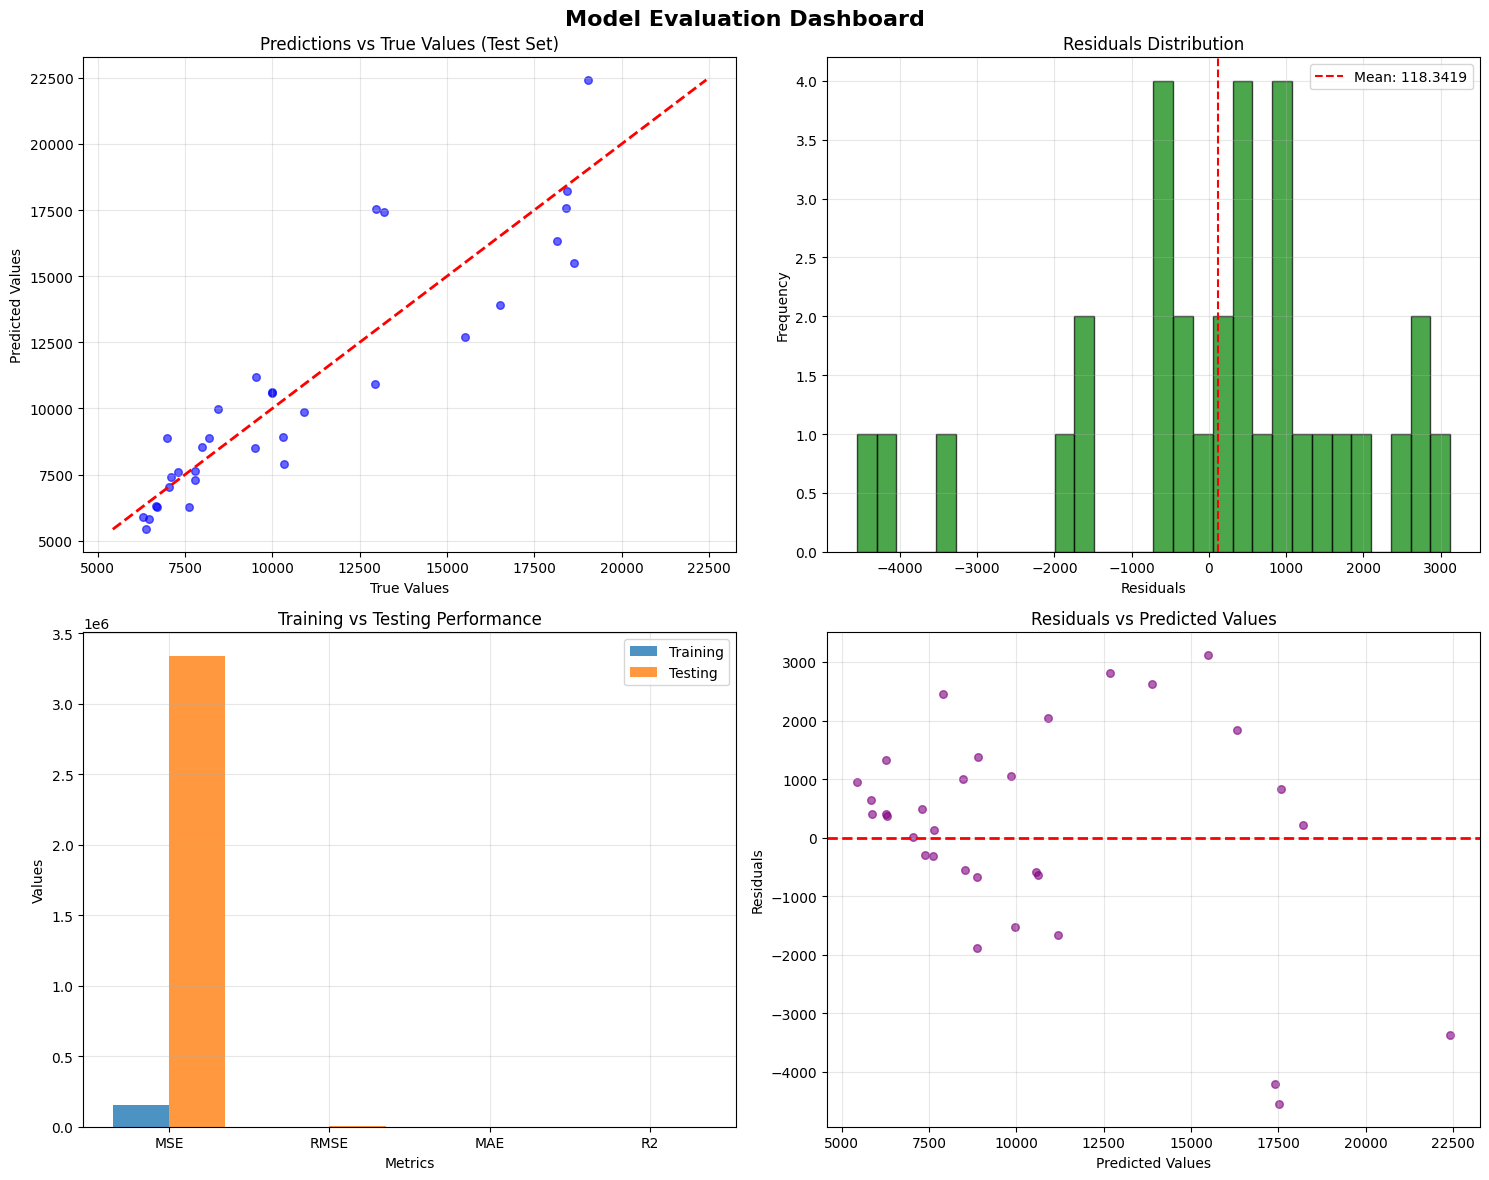

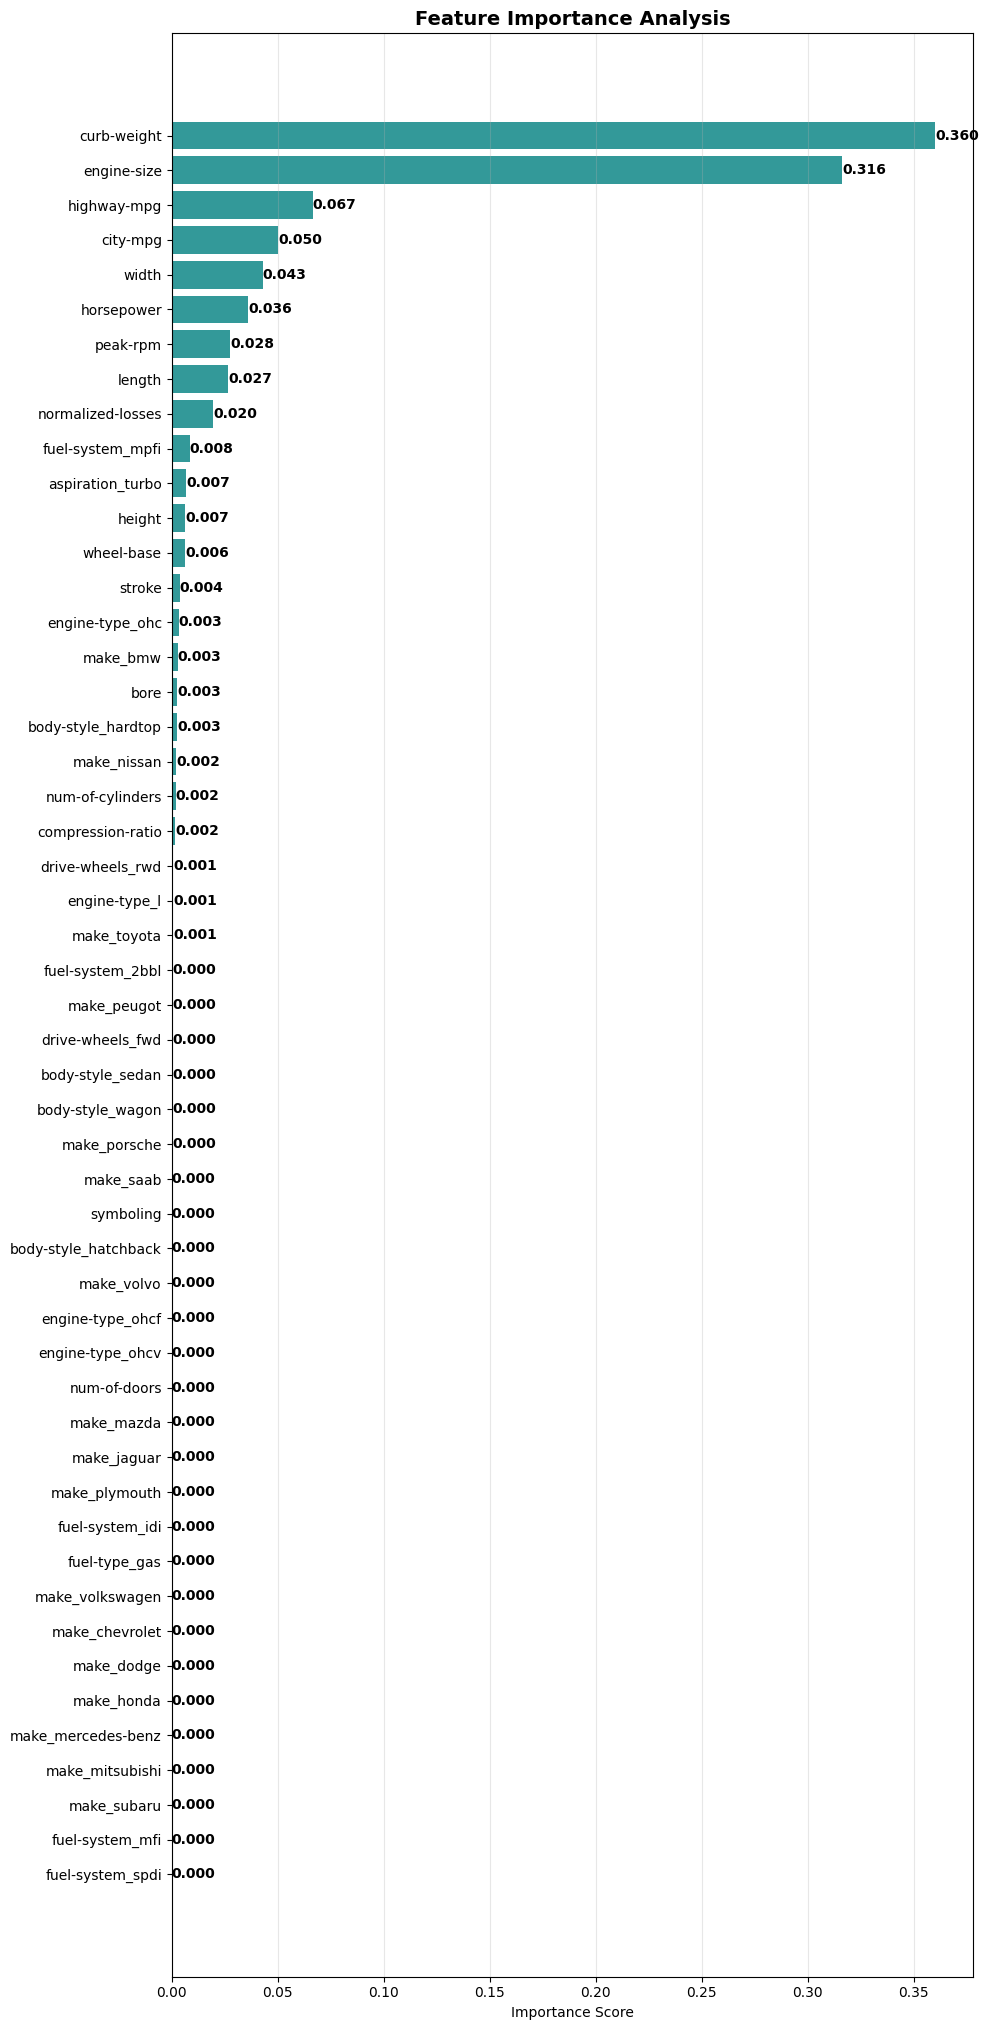


Hasil Evaluasi: {'MSE': 3339016.901939324, 'RMSE': np.float64(1827.2977047923318), 'R2': 0.8123581724855412}

Memproses Dataset: Infrared
Dataset loaded from https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/02.%20Deep%20Learning/Dataset/Infrared.csv
Dimensi Dataset: (1020, 34)
Kolom yang tersedia: ['Gender', 'Age', 'Ethnicity', 'T_atm', 'Humidity', 'Distance', 'T_offset1', 'Max1R13_1', 'Max1L13_1', 'aveAllR13_1', 'aveAllL13_1', 'T_RC1', 'T_RC_Dry1', 'T_RC_Wet1', 'T_RC_Max1', 'T_LC1', 'T_LC_Dry1', 'T_LC_Wet1', 'T_LC_Max1', 'RCC1', 'LCC1', 'canthiMax1', 'canthi4Max1', 'T_FHCC1', 'T_FHRC1', 'T_FHLC1', 'T_FHBC1', 'T_FHTC1', 'T_FH_Max1', 'T_FHC_Max1', 'T_Max1', 'T_OR1', 'T_OR_Max1', 'aveOralM']
GRADIENT BOOSTING MODEL EVALUATION RESULTS

📊 TRAINING SET PERFORMANCE:
   MSE     :     0.0243
   RMSE    :     0.1560
   MAE     :     0.1228
   R2      :     0.9114
   MAPE    :     0.3319

🎯 TESTING SET PERFORMANCE:
   MSE     :     0.0588
   RMSE    :     0.2424
   MAE     :    

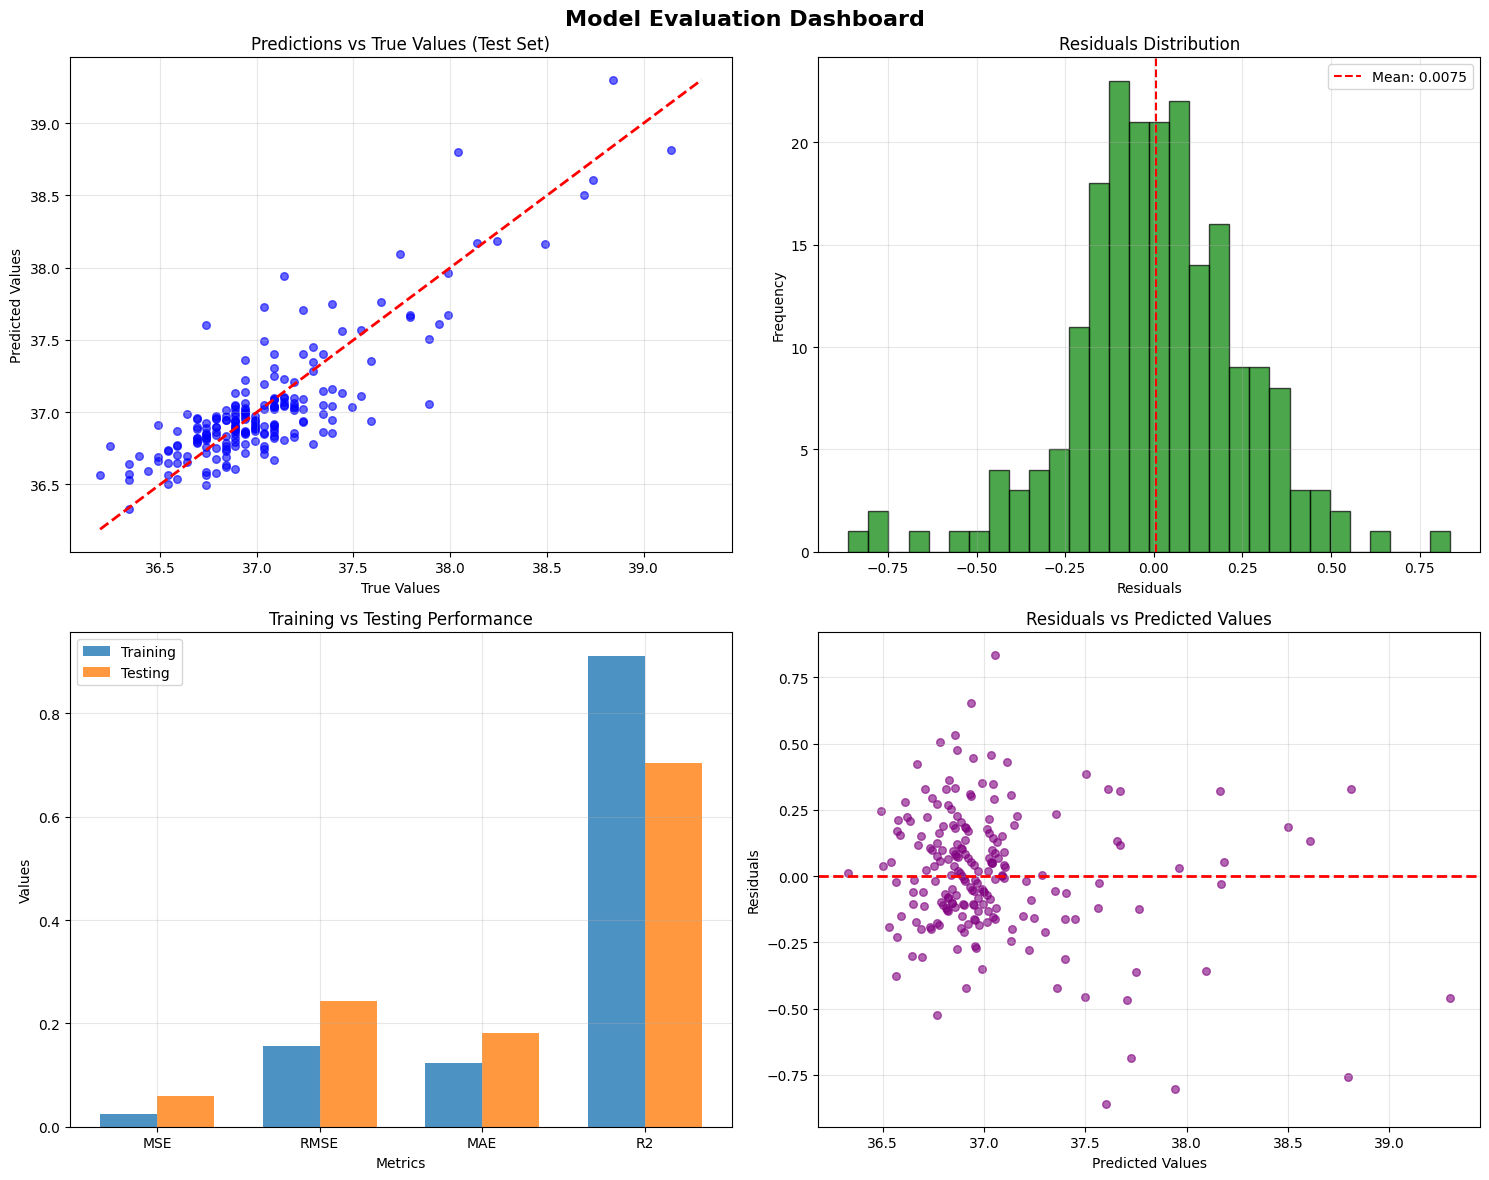

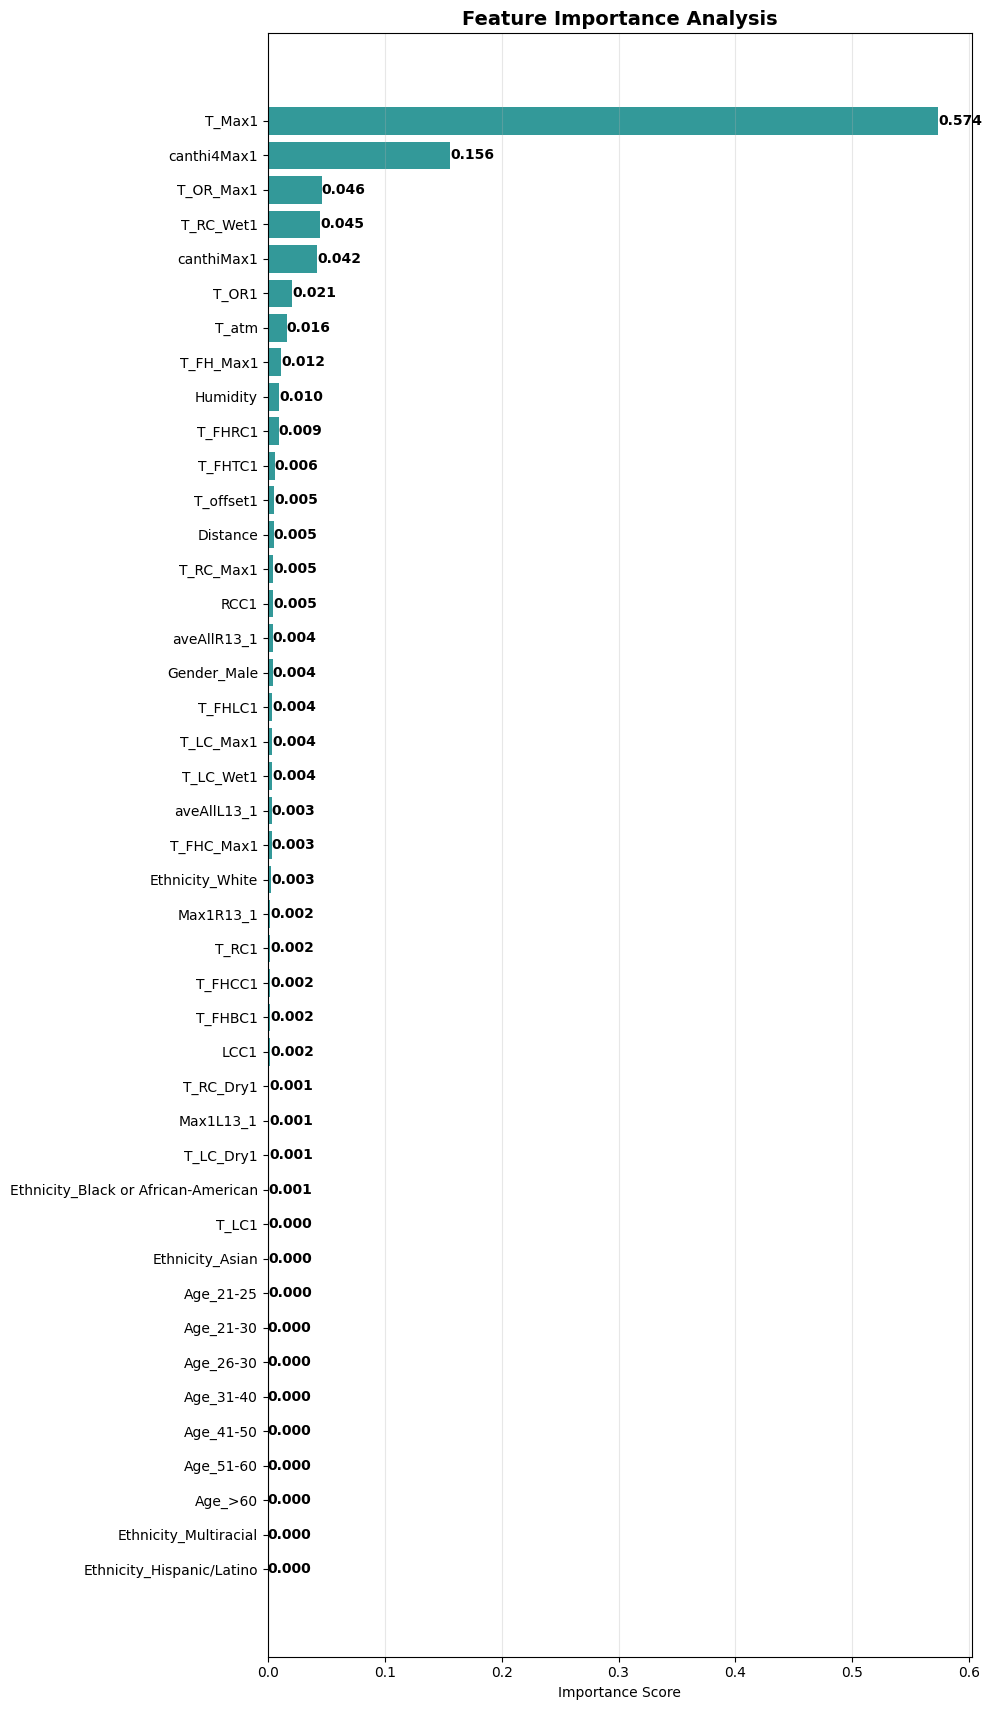


Hasil Evaluasi: {'MSE': 0.058776090409754775, 'RMSE': np.float64(0.2424378073027282), 'R2': 0.7045263074521939}

Memproses Dataset: BostonHousing
Dataset loaded from https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv
Dimensi Dataset: (506, 14)
Kolom yang tersedia: ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat', 'medv']
GRADIENT BOOSTING MODEL EVALUATION RESULTS

📊 TRAINING SET PERFORMANCE:
   MSE     :     1.7349
   RMSE    :     1.3171
   MAE     :     1.0438
   R2      :     0.9800
   MAPE    :     5.4275

🎯 TESTING SET PERFORMANCE:
   MSE     :     6.2089
   RMSE    :     2.4918
   MAE     :     1.9122
   R2      :     0.9153
   MAPE    :    10.0594

🔄 CROSS-VALIDATION RESULTS:
   CV_MSE_mean :    12.8684
   CV_MSE_std  :     5.2476
   CV_R2_mean  :     0.8512
   CV_R2_std   :     0.0546

⚙️  MODEL PARAMETERS:
   n_estimators      : 100
   learning_rate     : 0.1
   max_depth         : 3
   random_state     

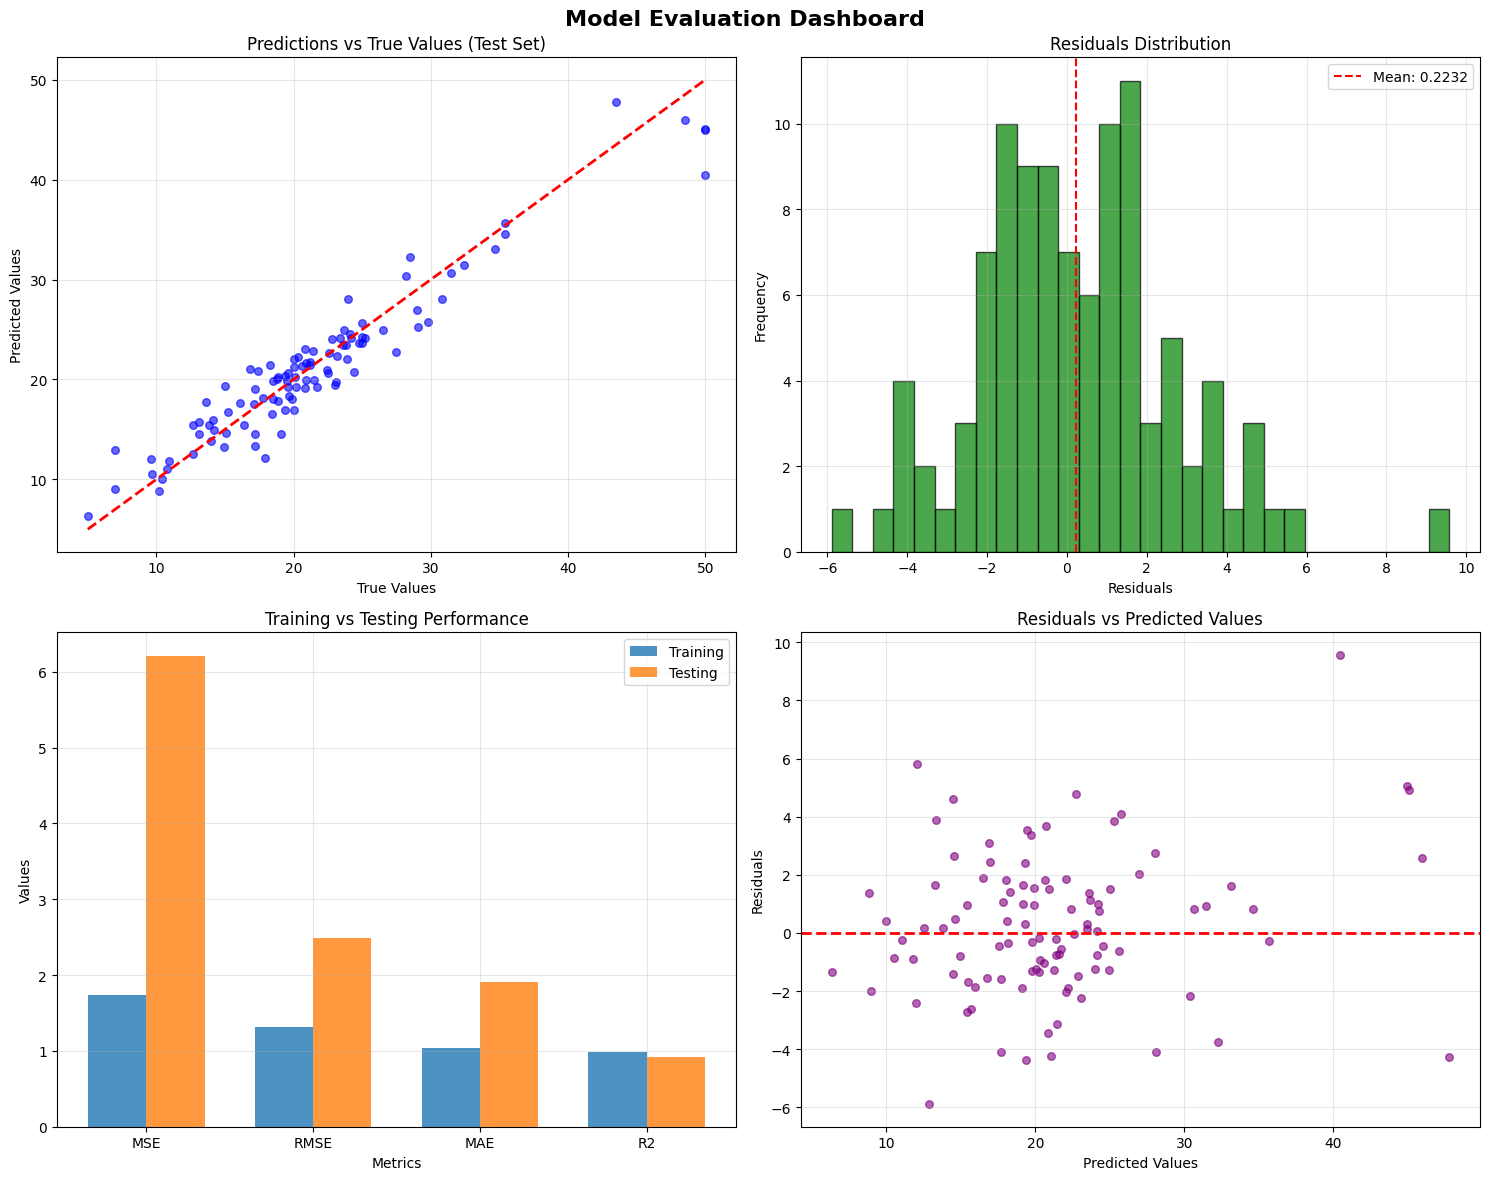

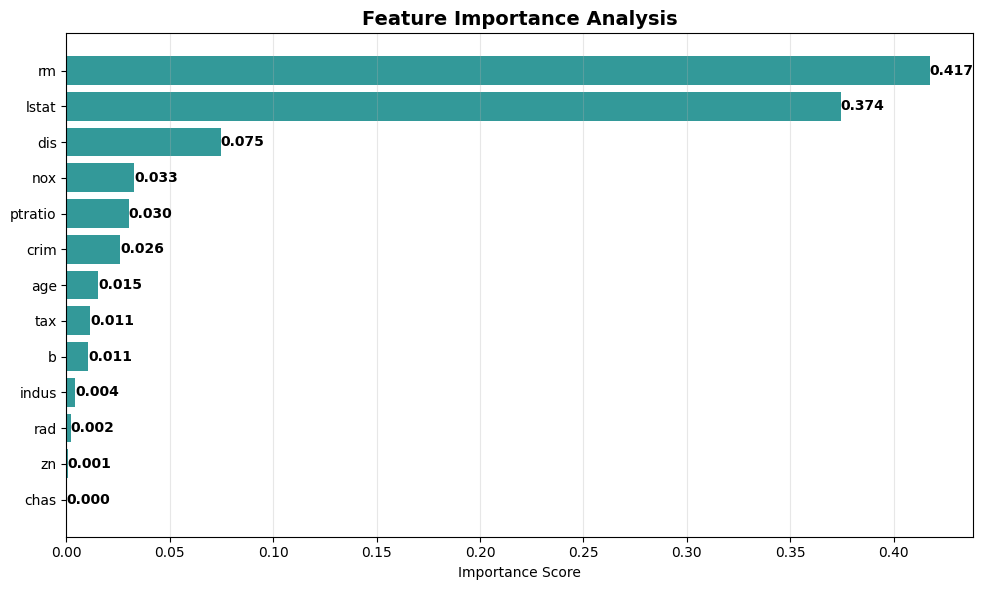


Hasil Evaluasi: {'MSE': 6.208861361528038, 'RMSE': np.float64(2.491758688462436), 'R2': 0.9153342280466539}


In [10]:
datasets = {
    "Automobile": {
        "url": "https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/01.%20Machine%20Learning/01.%20Week%201/Dataset/Automobile.csv",
        "target_col": "price"  # Sesuaikan jika perlu
    },
    "Infrared": {
        "url": "https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/02.%20Deep%20Learning/Dataset/Infrared.csv",
        "target_col": None  # Akan menggunakan kolom terakhir
    },
    "BostonHousing": {
        "url": "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv",
        "target_col": "medv"
    }
}

# Menyimpan hasil evaluasi tiap dataset
evaluasi_semua = {}

# Melakukan iterasi untuk tiap dataset dan menerapkan pipeline training-evaluasi
for ds_name, info in datasets.items():
    print("\n" + "="*60)
    print(f"Memproses Dataset: {ds_name}")
    print("="*60)

    # Memuat data dan menentukan fitur dan target
    df, X, y = load_dataset(info["url"], target_col=info["target_col"])

    # Melatih model boosting dan evaluasi
    eval_metrics = train_evaluate_boosting(X, y)
    evaluasi_semua[ds_name] = eval_metrics

    print("\nHasil Evaluasi:", eval_metrics)

## 📊 **Gradient Boosting - Penjelasan Matematika Sederhana**

### **🎯 Konsep Dasar**
Gradient Boosting adalah teknik yang membangun model prediksi secara bertahap. Bayangkan seperti belajar dari kesalahan - setiap langkah kita perbaiki kesalahan sebelumnya.

### **🔢 Rumus Matematis Utama**

**1. Model Akhir:**
```
F(x) = F₀ + η × h₁(x) + η × h₂(x) + ... + η × hₘ(x)
```
- F(x) = prediksi akhir
- F₀ = prediksi awal (biasanya rata-rata target)
- η = learning rate (seberapa cepat belajar)
- hₘ(x) = tree ke-m
- M = total jumlah tree

**2. Proses Iteratif:**
```
F₀(x) = argmin Σ L(yᵢ, γ)  → biasanya = mean(y)

Untuk m = 1 sampai M:
  - Hitung residual: rᵢₘ = -∂L(yᵢ, Fₘ₋₁(xᵢ))/∂Fₘ₋₁(xᵢ)
  - Fit tree hₘ(x) untuk memprediksi residual
  - Update: Fₘ(x) = Fₘ₋₁(x) + η × hₘ(x)
```

### **📈 Fungsi Loss (Mean Squared Error)**
```
L(y, F(x)) = ½(y - F(x))²

Gradiennya: ∂L/∂F = -(y - F(x)) = residual
```

### **🌳 Contoh Sederhana (3 Iterasi)**

**Data:** y = [10, 20, 30], prediksi awal F₀ = 20

**Iterasi 1:**
- Residual: [-10, 0, 10]
- Tree h₁ memprediksi residual ini
- Update: F₁(x) = 20 + 0.1 × h₁(x)

**Iterasi 2:**
- Hitung residual baru dari F₁
- Tree h₂ memprediksi residual baru
- Update: F₂(x) = F₁(x) + 0.1 × h₂(x)

**Iterasi 3:**
- Proses sama, terus perbaiki kesalahan
- F₃(x) = F₂(x) + 0.1 × h₃(x)

### **⚙️ Parameter Penting**

**Learning Rate (η):**
- Nilai 0.01-0.3 (biasanya 0.1)
- Kecil = pembelajaran lambat tapi stabil
- Besar = pembelajaran cepat tapi bisa overfitting

**Max Depth:**
- Kedalaman setiap tree (biasanya 3-8)
- Shallow tree = bias tinggi, variance rendah
- Deep tree = bias rendah, variance tinggi

**N_estimators:**
- Jumlah total tree
- Lebih banyak = model kompleks
- Trade-off antara akurasi vs overfitting

### **🎯 Kenapa Gradient Boosting Powerful?**

1. **Fokus pada Kesalahan:** Setiap tree belajar dari kesalahan tree sebelumnya
2. **Ensemble Power:** Kombinasi banyak weak learner jadi strong learner  
3. **Flexible:** Bisa handle non-linear relationship
4. **Robust:** Tidak mudah overfitting jika parameter tepat

### **📊 Interpretasi Metrics**

**R² Score:**
```
R² = 1 - (SS_res / SS_tot)
- SS_res = Σ(y_true - y_pred)²
- SS_tot = Σ(y_true - y_mean)²
```
- R² = 0.9 → Model menjelaskan 90% variasi data
- R² = 0.5 → Model menjelaskan 50% variasi data

**RMSE (Root Mean Square Error):**
```
RMSE = √(Σ(y_true - y_pred)² / n)
```
- Satuan sama dengan target variable
- Sensitif terhadap outlier
- Semakin kecil semakin baik

**MAE (Mean Absolute Error):**
```
MAE = Σ|y_true - y_pred| / n  
```
- Lebih robust terhadap outlier
- Interpretasi lebih mudah

### **🔧 Tips Praktis**

**Cegah Overfitting:**
- Gunakan learning_rate kecil + n_estimators besar
- Batasi max_depth (3-6 cukup)
- Gunakan subsample < 1.0

**Improve Performance:**
- Feature engineering lebih penting dari tuning parameter
- Cross-validation untuk pilih parameter optimal
- Ensemble dengan algoritma lain

Intinya: Gradient Boosting = **"Belajar dari kesalahan secara bertahap"** dengan matematik yang solid! 🚀